In [32]:
# Imports req here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.utils.data as data_utils

from skimage import io, transform
from PIL import Image, ImageFile
import json
import time
import os
import argparse
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm_notebook
import seaborn as sns

data_dir = "aptos2019-blindness-detection"
torch.cuda.empty_cache()

# Loading Data


In [72]:
train_csv = pd.read_csv('aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('aptos2019-blindness-detection/test.csv')
print('Number of Train Images  = {}'.format(len(train_csv)))
print('Number of Test Images = {}'.format(len(test_csv)))

Number of Train Images  = 3662
Number of Test Images = 1928


In [34]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


/home/ali/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


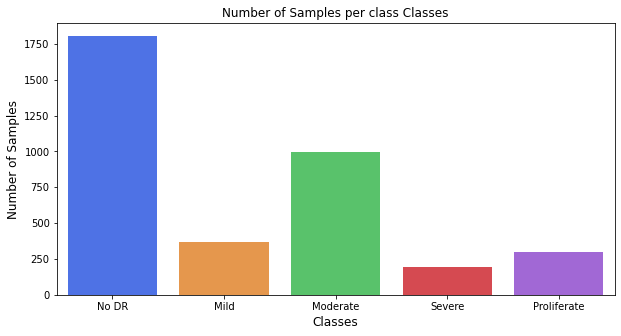

In [65]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)
plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Number of Samples per class Classes')
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.show()

# Visualizing Training Data

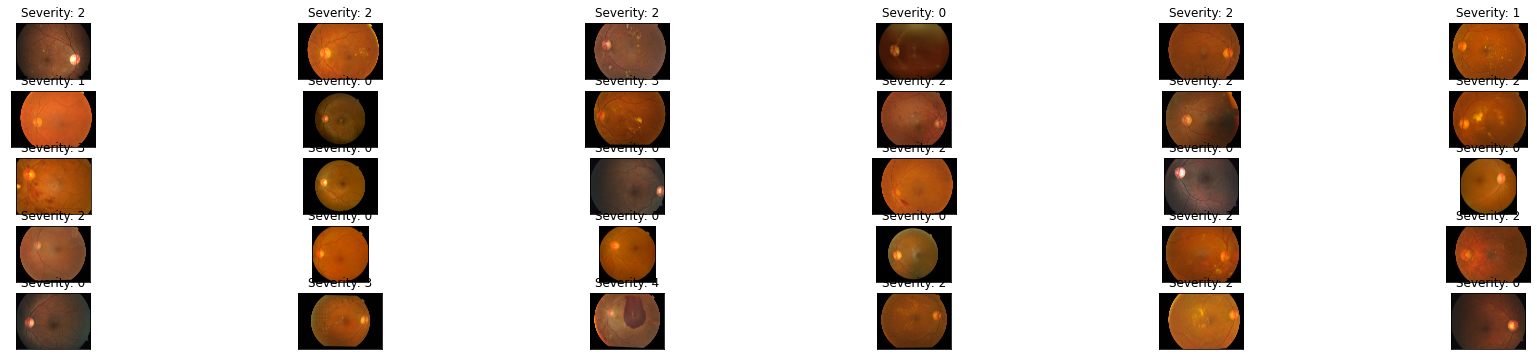

In [63]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
num_imgtoshow = 30
train_imgs = os.listdir(data_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, num_imgtoshow)):
    ax = fig.add_subplot(5, num_imgtoshow//5, idx+1, xticks=[], yticks=[])
    im = Image.open(data_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Data Processing

In [37]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = 'data', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [38]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [39]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [40]:
train_path = "aptos2019-blindness-detection/train_images/"
test_path = "aptos2019-blindness-detection/test_images/"

In [41]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
    

In [42]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [43]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [74]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=256,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=256, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)
print(f"Training samples : {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(len(trainloader))
print(len(validloader))
print(len(testloader))

Training samples : 3662
Testing samples : 1928
12
3
8


In [75]:
# Checking some of images data and the labels
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")
print('labels:', labels)    


Image shape : torch.Size([256, 3, 224, 224])
Label shape : torch.Size([256])
labels: tensor([0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 1, 2, 2, 0, 2, 4, 1, 0, 2, 1, 0, 4, 0, 4,
        2, 4, 0, 2, 2, 2, 0, 0, 2, 2, 0, 4, 0, 4, 3, 2, 1, 1, 3, 0, 2, 0, 0, 2,
        0, 0, 4, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 3, 2, 1, 4, 0, 0, 0, 0, 2, 1, 0,
        0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 2, 0, 4, 0, 1, 4, 0, 0, 2, 0, 1,
        0, 0, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 4, 2, 3, 0, 1, 2, 4, 0, 0, 1,
        0, 0, 0, 0, 2, 2, 3, 0, 2, 4, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2,
        1, 4, 2, 1, 0, 0, 3, 0, 4, 0, 4, 3, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1,
        0, 2, 2, 2, 2, 2, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 3, 2, 0, 2, 4, 2, 0, 2,
        2, 2, 0, 0, 3, 2, 0, 4, 2, 1, 0, 2, 4, 2, 2, 0, 0, 2, 1, 4, 0, 0, 2, 0,
        0, 0, 0, 2, 2, 1, 4, 0, 0, 4, 0, 0, 0, 2, 2, 4, 0, 2, 0, 3, 0, 0, 2, 0,
        0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0])


In [49]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True) 
num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [51]:
model_save_name = 'classifier.pt'
path = F"models/{model_save_name}"

In [52]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [53]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [54]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [71]:
if os.path.isfile("models/classifier.pt"): 
    print("Loading Pre-trained model")
    model = load_model("models/classifier.pt")


Loading Pre-trained model


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

In [ ]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [ ]:
train_losses, valid_losses, acc = train_and_test(5)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label    ='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)